In [2]:
import numpy as np
import pandas as pd
import os
from os import listdir
from os.path import isfile, join
import zipfile
import matplotlib.pyplot as plt
import seaborn as sns 
from scipy.stats import zscore
from scipy import fftpack
import random
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.decomposition import PCA
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.preprocessing import LabelEncoder
import optuna


c:\Users\ameer\anaconda3\envs\myenv\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [127]:
my_path = "C:/Users/ameer/Desktop/AI/ML4QS/Our data"

onlyfiles = [f for f in listdir(my_path) if isfile(join(my_path, f))]
onlyfolds = [f for f in listdir(my_path) if not isfile(join(my_path, f))]
all_files_and_folds = listdir(my_path)

In [64]:
def renaming_func(some_df):
    col_names = some_df.columns
    for nms in col_names:
        if "Time" in nms:
            some_df = some_df.rename(columns={nms:"time"})
        elif "X " in nms or " x " in nms:
            some_df = some_df.rename(columns={nms:"x"})
        elif "Y " in nms or " y " in nms:
            some_df = some_df.rename(columns={nms:"y"})
        elif "Z " in nms or " z " in nms:
            some_df = some_df.rename(columns={nms:"z"})
        elif "Pressure" in nms:
            some_df = some_df.rename(columns={nms:"pressure"})
        # else:
        #     some_df = some_df.rename(columns={nms:"source_name"})
    return some_df

In [65]:
acel = "Accelerometer.csv" 
linear_acel = "Linear Accelerometer.csv"
gyro = "Gyroscope.csv"
baro = "Barometer.csv"

file_names = [acel, linear_acel, gyro, baro]
file_names2 = ["Accelerometer.csv", "Linear Acceleration.csv", "Gyroscope.csv", "Pressure.csv"]

In [66]:
# combine data in already unzipped folders

accel_df1 = pd.DataFrame(columns=["time", "x", "y", "z","source_name"],dtype=object)
lin_accel_df1 = pd.DataFrame(columns=["time", "x", "y", "z","source_name"],dtype=object)
gyro_df1 = pd.DataFrame(columns=["time", "x", "y", "z","source_name"],dtype=object)
baro_df1 = pd.DataFrame(columns=["time", "x", "source_name"],dtype=object)

df_list = [accel_df1,lin_accel_df1,gyro_df1,baro_df1]

for i in onlyfolds: #iterate through folders of social media measurements eg. "Red4 2024-06-06 20-02-55"
    for count,j in enumerate(file_names): #iterate through files in the folder
        my_df = pd.read_csv(my_path+"/"+str(i)+"/"+j) #read the tables in it
        my_df["source_name"] = str(i).split()[0] #add the name of Social Media source to a column in the dataset
        my_df = renaming_func(my_df) #simplify column names
        df_list[count] = pd.concat([df_list[count], my_df], ignore_index=True)
        
accel_df1 = df_list[0]
lin_accel_df1 = df_list[1]
gyro_df1 = df_list[2]
baro_df1 = df_list[3]

In [40]:
# #This is imputing missing gyroscope data in Reddit2

# all_gyroscope_df = pd.read_csv("C:/Users/ameer/Desktop/AI/ML4QS/all gyroscope data.csv")
# temp_df = pd.DataFrame(columns=['X (rad/s)_2', 'Y (rad/s)_2', 'Z (rad/s)_2'], dtype = object)

# X_col_ind = [i for i, cols in enumerate(all_gyroscope_df.columns) if "X (rad/s)" in cols]
# Y_col_ind = [i for i, cols in enumerate(all_gyroscope_df.columns) if "Y (rad/s)" in cols]
# Z_col_ind = [i for i, cols in enumerate(all_gyroscope_df.columns) if "Z (rad/s)" in cols]


# def process_gyro_rows(row, temp_df=temp_df):
#     sample_x = np.random.normal(loc=row[X_col_ind].mean(), scale=row[X_col_ind].std(), size=1)
#     sample_y = np.random.normal(loc=row[Y_col_ind].mean(), scale=row[Y_col_ind].std(), size=1)
#     sample_z = np.random.normal(loc=row[Z_col_ind].mean(), scale=row[Z_col_ind].std(), size=1)
#     new_row = [sample_x, sample_y, sample_z]
#     temp_df.loc[len(temp_df)] = new_row

# for index, rows in all_gyroscope_df.iterrows():
#     process_gyro_rows(row=rows)

# all_gyroscope_df = pd.concat([all_gyroscope_df, temp_df], axis=1)

# all_gyroscope_df = all_gyroscope_df.apply(pd.Series.explode)
# temp_df = temp_df.apply(pd.Series.explode)
# temp_df["Time (s)"] = all_gyroscope_df["Time (s)"]

# temp_df.to_csv('C:/Users/ameer/Desktop/AI/ML4QS/Gyroscope.csv', index=False)

In [67]:
#combine data in zipped files

accel_df2 = pd.DataFrame(columns=["time", "x", "y", "z","source_name"],dtype=object)
lin_accel_df2 = pd.DataFrame(columns=["time", "x", "y", "z","source_name"],dtype=object)
gyro_df2 = pd.DataFrame(columns=["time", "x", "y", "z","source_name"],dtype=object)
baro_df2 = pd.DataFrame(columns=["time", "x", "source_name"],dtype=object)

df_list2 = [accel_df2,lin_accel_df2,gyro_df2,baro_df2]
deicde_list = lambda x: file_names2 if ("FB" in x) else file_names

for i in onlyfiles: #names of zip files
        for count, j in enumerate(deicde_list(i)): #names of csv files
                with zipfile.ZipFile(my_path+"/"+str(i), 'r') as zip_ref: #unzip the zip file
                        with zip_ref.open(j) as file: #take out the csv file
                            my_df = pd.read_csv(file) #have the csv in a df
                            my_df["source_name"] = str(i).split()[0] #add the name of the source 
                            my_df = renaming_func(my_df) #change the names of the columns
                            df_list2[count] = pd.concat([df_list2[count], my_df], ignore_index=True) #take out the df and append the data to it

accel_df2 = df_list2[0]
lin_accel_df2 = df_list2[1]
gyro_df2 = df_list2[2]
baro_df2 = df_list2[3]
baro_df2['x'] = baro_df2['x'].fillna(baro_df2['pressure'])
baro_df2 = baro_df2.drop(columns=['pressure'])

In [68]:
accel_df1 = pd.concat([accel_df1,accel_df2], ignore_index=True)
lin_accel_df1 = pd.concat([lin_accel_df1,lin_accel_df2], ignore_index=True)
gyro_df1 = pd.concat([gyro_df1,gyro_df2], ignore_index=True)
baro_df1 = pd.concat([baro_df1,baro_df2], ignore_index=True)

In [69]:
my_path = 'C:/Users/ameer/Desktop/AI/ML4QS/ml4qs_social_app/Emir_Datasets'

accel_df1.to_parquet(my_path+"/"+"all_acceleration.parquet.gzip", index = False,compression='gzip')
lin_accel_df1.to_parquet(my_path+"/"+"all_lin_acceleration.parquet.gzip", index = False,compression='gzip')
gyro_df1.to_parquet(my_path+"/"+"all_gyroscope.parquet.gzip", index = False,compression='gzip')
baro_df1.to_parquet(my_path+"/"+"all_barometer.parquet.gzip", index = False,compression='gzip')

In [70]:
my_path = 'C:/Users/ameer/Desktop/AI/ML4QS/ml4qs_social_app/Emir_Datasets'

accel = pd.read_parquet(my_path+"/all_acceleration.parquet.gzip")
lin_accel = pd.read_parquet(my_path+"/all_lin_acceleration.parquet.gzip")
baro = pd.read_parquet(my_path+"/all_barometer.parquet.gzip")
gyro = pd.read_parquet(my_path+"/all_gyroscope.parquet.gzip")

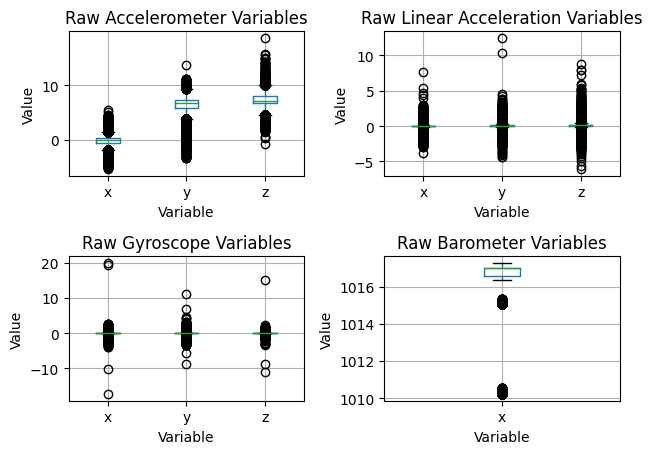

In [30]:
plt.subplot(2, 2, 1)
accel.iloc[:,1:].boxplot()
plt.title('Raw Accelerometer Variables')
plt.suptitle('')  # Suppress the automatic title to keep the plot clean
plt.xlabel('Variable')
plt.ylabel('Value')

plt.subplot(2, 2, 2)
lin_accel.iloc[:,1:].boxplot()
plt.title('Raw Linear Acceleration Variables')
plt.suptitle('')  # Suppress the automatic title to keep the plot clean
plt.xlabel('Variable')
plt.ylabel('Value')

plt.subplot(2, 2, 3)
gyro.iloc[:,1:].boxplot()
plt.title('Raw Gyroscope Variables')
plt.suptitle('')  # Suppress the automatic title to keep the plot clean
plt.xlabel('Variable')
plt.ylabel('Value')

plt.subplot(2, 2, 4)
baro.iloc[:,1:].boxplot()
plt.title('Raw Barometer Variables')
plt.suptitle('')  # Suppress the automatic title to keep the plot clean
plt.xlabel('Variable')
plt.ylabel('Value')

plt.tight_layout()

In [31]:
# accel.set_index('time', inplace=True)
# baro.set_index('time', inplace=True)
# gyro.set_index('time', inplace=True)
# lin_accel.set_index('time', inplace=True)

# datasets = [accel, baro, gyro, lin_accel]

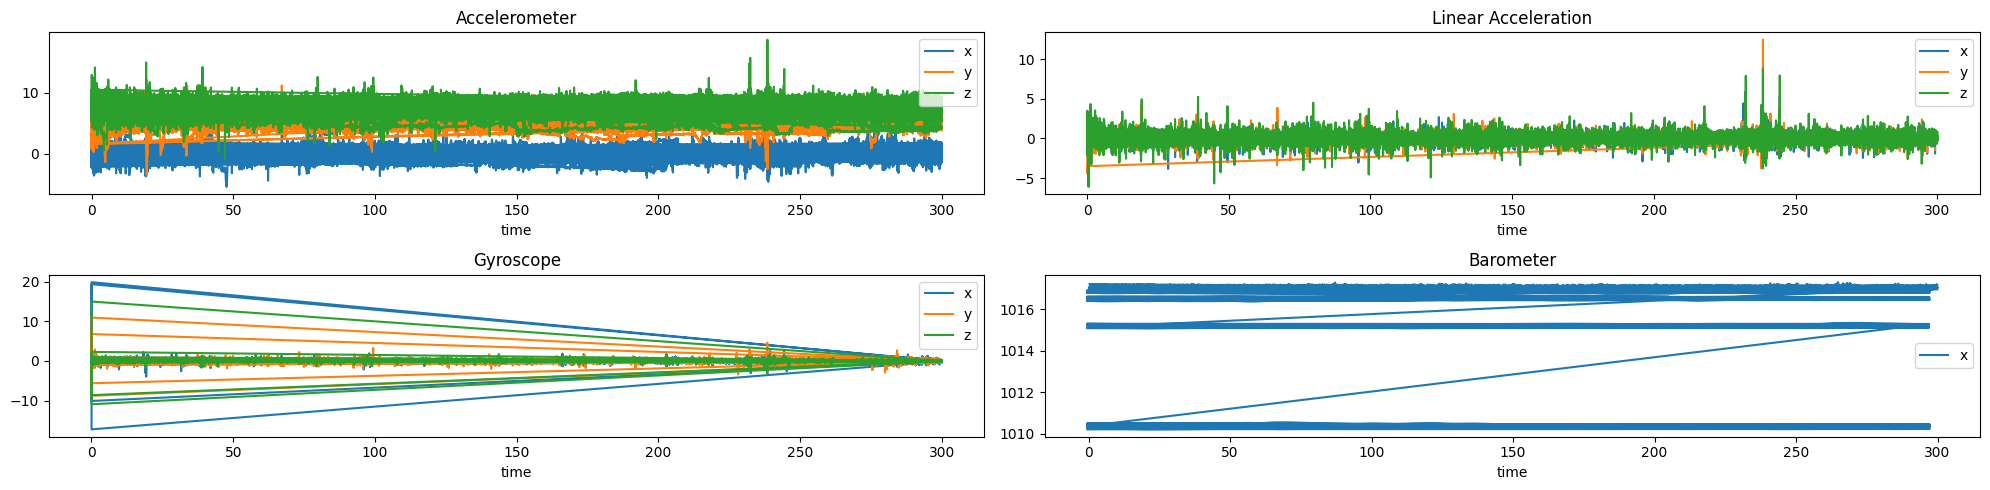

In [33]:
fig, axs = plt.subplots(2, 2, figsize=(20, 5))

accel.plot(ax=axs[0,0])
axs[0,0].set_title('Accelerometer')

lin_accel.plot(ax=axs[0,1])
axs[0,1].set_title('Linear Acceleration')

# Plot dataset3 on the third subplot
gyro.plot(ax=axs[1,0])
axs[1,0].set_title('Gyroscope')

# Plot dataset4 on the fourth subplot
baro.plot(ax=axs[1,1])
axs[1,1].set_title('Barometer')

plt.tight_layout()


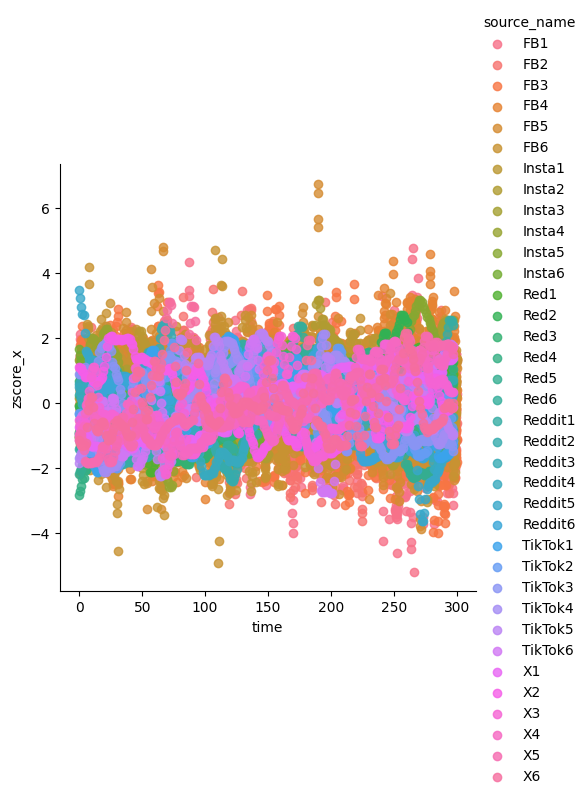

In [271]:
sns.lmplot(x='time', y='x', data=baro, hue='source_name', fit_reg=False)

<Axes: xlabel='time', ylabel='y'>

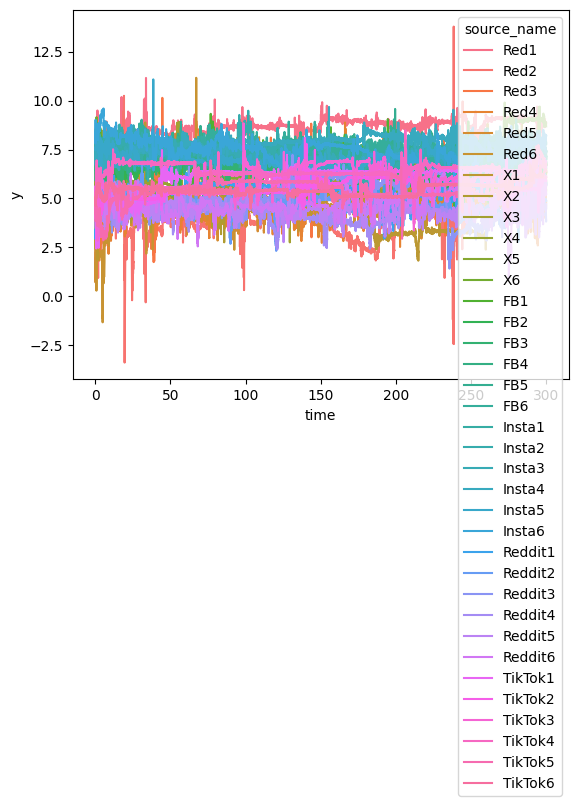

In [213]:
sns.lineplot(x='time', y='y', data=accel[["time","y", "source_name"]], hue='source_name')

In [71]:
my_path = "C:/Users/ameer/Desktop/AI/ML4QS/ml4qs_social_app/Emir_Datasets"

accel = pd.read_parquet(my_path+"/"+"all_acceleration.parquet.gzip")
lin_accel = pd.read_parquet(my_path+"/"+"all_lin_acceleration.parquet.gzip")
gyro = pd.read_parquet(my_path+"/"+"all_gyroscope.parquet.gzip")
baro = pd.read_parquet(my_path+"/"+"all_barometer.parquet.gzip")

In [72]:
def inclination_extractor(some_df, axis_1="y", axis_2 = "z" ):
    return np.degrees(np.arctan2(some_df[axis_1], some_df[axis_2]))

accel['vertical_inclination'] = inclination_extractor(accel)
accel['horizontal_inclination'] = inclination_extractor(accel, "y", "x")

my_path = 'C:/Users/ameer/Desktop/AI/ML4QS/ml4qs_social_app/Emir_Datasets'

accel.to_parquet(my_path+"/"+"all_acceleration.parquet.gzip", index = False,compression='gzip')


In [132]:
def zscore_standardize_columns(some_df):

    results_df = pd.DataFrame()
    grouped = some_df.groupby('source_name')

    for name, group in grouped:
        temp_df = pd.DataFrame()
        group_df = group.copy()
        group_df = group_df.drop(columns=['time'])
        s = group_df.select_dtypes("number").columns
        temp_df[["zscore_"+x for x in group_df.loc[:,s].columns]] = group_df.loc[:,s].apply(zscore)
        temp_df[['time','source_name']] = group[['time','source_name']]
        results_df = pd.concat([results_df, temp_df])
    return results_df
        
        


In [75]:
new_baro = zscore_standardize_columns(baro)
new_accel = zscore_standardize_columns(accel)
new_lin_accel = zscore_standardize_columns(lin_accel)
new_gyro = zscore_standardize_columns(gyro)

all_baro = pd.merge(baro, new_baro, on = ['time', 'source_name'])
all_gyro = pd.merge(gyro, new_gyro, on = ['time', 'source_name'])
all_accel = pd.merge(accel, new_accel, on = ['time', 'source_name'])
all_lin_accel = pd.merge(lin_accel, new_lin_accel, on = ['time', 'source_name'])

my_path = 'C:/Users/ameer/Desktop/AI/ML4QS/ml4qs_social_app/Emir_Datasets'
all_accel.to_parquet(my_path+"/"+"all_acceleration.parquet.gzip", index = False,compression='gzip')
all_lin_accel.to_parquet(my_path+"/"+"all_lin_acceleration.parquet.gzip", index = False,compression='gzip')
all_gyro.to_parquet(my_path+"/"+"all_gyroscope.parquet.gzip", index = False,compression='gzip')
all_baro.to_parquet(my_path+"/"+"all_barometer.parquet.gzip", index = False,compression='gzip')

In [80]:
my_path = "C:/Users/ameer/Desktop/AI/ML4QS/ml4qs_social_app/Emir_Datasets"

accel = pd.read_parquet(my_path+"/"+"all_acceleration.parquet.gzip")
lin_accel = pd.read_parquet(my_path+"/"+"all_lin_acceleration.parquet.gzip")
gyro = pd.read_parquet(my_path+"/"+"all_gyroscope.parquet.gzip")
baro = pd.read_parquet(my_path+"/"+"all_barometer.parquet.gzip")

In [78]:
def fourier_transformer(some_column, sampling_interval=0.05):
    fft_column = np.fft.fft(some_column)
    frequencies = np.fft.fftfreq(len(fft_column), d=sampling_interval)
    power_spectrum = np.abs(fft_column)
    weighted_sum = np.sum(frequencies * power_spectrum)
    total_magnitude = np.sum(power_spectrum)
    frequency_weighted_avg = weighted_sum / total_magnitude
    dominant_frequency = frequencies[np.argmax(power_spectrum)]
    return dominant_frequency, frequency_weighted_avg

In [81]:
def resampler(some_df, rate='50L', method="downscale", expand_features = True, acceleretor_fourier = False):
    pd.options.mode.chained_assignment = None #remove the annoying warning
    
    # Create an empty DataFrame to store resampled data
    resampled_dfs = []

    # Group the DataFrame by 'source_name'
    grouped = some_df.groupby('source_name')
    
    # Iterate over each group
    for name, group in grouped:
        # Copy the group to avoid modifying the original DataFrame
        group_df = group.copy()
        group_df['time'] = pd.to_timedelta(group_df['time'], unit='s')
        
        # Set "time" as the index
        group_df.set_index('time', inplace=True)
        resampled_group = pd.DataFrame()
        if method=="downscale" or method=="d":
            # Resample the data to the specified frequency, and choose the extreme value always
           if expand_features:
            my_col_names = group_df.drop(columns=['source_name']).columns
            resampling = group_df.drop(columns=['source_name']).resample(rate)
            resampled_group[[x+"_max" for x in my_col_names]] = resampling.max().interpolate()
            resampled_group[[x+"_min" for x in my_col_names]] = resampling.min().interpolate()
            resampled_group[[x+"_sd" for x in my_col_names]] = resampling.std().interpolate()
            resampled_group[[x+"_mean" for x in my_col_names]] = resampling.mean().interpolate()
            if acceleretor_fourier:
                tmp = resampling.apply(lambda x : fourier_transformer(x, sampling_interval=float(''.join(filter(str.isdigit, rate)))*0.001))
                resampled_group[[x+"_dominant_freq" for x in my_col_names]] = tmp.applymap(lambda x: x[0])
                resampled_group[[x+"_avg_weigh_freq" for x in my_col_names]] = tmp.applymap(lambda x: x[1])
           else:
                resampled_group = group_df.drop(columns=['source_name']).resample(rate).apply(lambda x: max(x, key=abs)).interpolate()
           
        elif method == "upscale" or method=='u':
            resampled_group = group_df.drop(columns=['source_name']).resample(rate).ffill()
        #put back the source_name to the dataframe
        resampled_group['source_name'] = name
        
        # Reset the index to have "time" as a column again, and convert it back to readable seconds
        resampled_group.reset_index(inplace=True)
        resampled_group['time'] = resampled_group['time'].dt.total_seconds()

        # Store the resampled DataFrame for this category
        resampled_dfs.append(resampled_group)

    # Concatenate all resampled DataFrames into a single DataFrame
    resampled_df = pd.concat(resampled_dfs)
    
    # Return the resampled DataFrame
    return resampled_df

In [82]:
accel_resampled = resampler(accel, acceleretor_fourier = True)
lin_accel_resampled = resampler(lin_accel, acceleretor_fourier = True)
gyro_resampled = resampler(gyro)

#for baro, use method="d" if resampling for 1 sec
baro_resampled = resampler(baro, method="u") #since baro data are have rough granulaity in the raw data (~1 measurement/sec), we expand each measurement to duplicate values for each 0.05 sec (ie. downscaling)

In [84]:
my_path = "C:/Users/ameer/Desktop/AI/ML4QS/ml4qs_social_app/Emir_Datasets"

accel_resampled.to_parquet(my_path+"/"+"accel_resampled.parquet.gzip", compression='gzip')
lin_accel_resampled.to_parquet(my_path+"/"+"lin_accel_resampled.parquet.gzip", compression='gzip')
gyro_resampled.to_parquet(my_path+"/"+"gyro_resampled.parquet.gzip", compression='gzip')
baro_resampled.to_parquet(my_path+"/"+"baro_resampled.parquet.gzip", compression='gzip')

In [ ]:
accel_resampled_hz = resampler(accel, acceleretor_fourier = True, rate="1000L")
lin_accel_resampled_hz = resampler(lin_accel, acceleretor_fourier = True, rate="1000L")
gyro_resampled_hz = resampler(gyro, rate="1000L", acceleretor_fourier = True)

#for baro, use method="d" if resampling for 1 sec
baro_resampled_hz = resampler(baro, rate="1000L") #since baro data are have rough granulaity in the raw data (~1 measurement/sec), we expand each measurement to duplicate values for each 0.05 sec (ie. downscaling)

In [87]:
my_path = "C:/Users/ameer/Desktop/AI/ML4QS/ml4qs_social_app/Emir_Datasets"

accel_resampled_hz.to_parquet(my_path+"/"+"accel_resampled_1hz.parquet.gzip", compression='gzip')
lin_accel_resampled_hz.to_parquet(my_path+"/"+"lin_accel_resampled_1hz.parquet.gzip", compression='gzip')
gyro_resampled_hz.to_parquet(my_path+"/"+"gyro_resampled_1hz.parquet.gzip", compression='gzip')
baro_resampled_hz.to_parquet(my_path+"/"+"baro_resampled_1hz.parquet.gzip", compression='gzip')

In [88]:
my_path = "C:/Users/ameer/Desktop/AI/ML4QS/ml4qs_social_app/Emir_Datasets"

accel_resampled = pd.read_parquet(my_path+"/"+"accel_resampled.parquet.gzip")
lin_accel_resampled = pd.read_parquet(my_path+"/"+"lin_accel_resampled.parquet.gzip")
gyro_resampled = pd.read_parquet(my_path+"/"+"gyro_resampled.parquet.gzip")
baro_resampled = pd.read_parquet(my_path+"/"+"baro_resampled.parquet.gzip")

In [89]:
def visualizer(first_source_name, second_source_name, var = "x_mean"):
    plt.plot(accel_resampled[accel_resampled['source_name']==first_source_name]['time'],accel_resampled[accel_resampled['source_name']==first_source_name][var], color = 'green', alpha = 1)
    plt.plot(accel_resampled[accel_resampled['source_name']==second_source_name]['time'],accel_resampled[accel_resampled['source_name']==second_source_name][var], color = 'red', alpha = 0.5)

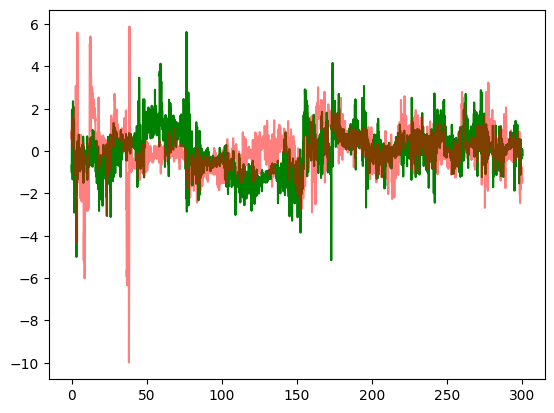

In [90]:
visualizer('FB1', 'Insta5', 'zscore_x_mean')

In [91]:
accel_resampled = accel_resampled.rename(columns=lambda x: "accel_" + x)
accel_resampled = accel_resampled.rename(columns= {"accel_time":"time", "accel_source_name":"source_name"})
lin_accel_resampled = lin_accel_resampled.rename(columns=lambda x: "linaccel_" + x)
lin_accel_resampled = lin_accel_resampled.rename(columns= {"linaccel_time":"time", "linaccel_source_name":"source_name"})
gyro_resampled = gyro_resampled.rename(columns=lambda x: "gyro_" + x)
gyro_resampled = gyro_resampled.rename(columns= {"gyro_time":"time", "gyro_source_name":"source_name"})
baro_resampled = baro_resampled.rename(columns=lambda x: "baro_" + x)
baro_resampled = baro_resampled.rename(columns= {"baro_time":"time", "baro_source_name":"source_name"})


In [92]:
def indexing_func(df):
    indecies = []
    grouped = df.groupby('source_name')
    for name, group in grouped:
        indecies.extend(np.arange(0,len(group)))
    return indecies


In [93]:
accel_resampled["index"] = indexing_func(accel_resampled)
lin_accel_resampled["index"] = indexing_func(lin_accel_resampled)
gyro_resampled["index"] = indexing_func(gyro_resampled)
baro_resampled["index"] = indexing_func(baro_resampled)

In [94]:
merged_df = pd.merge(accel_resampled, lin_accel_resampled, on=['index', 'source_name'], suffixes=('_accel', '_linaccel'))
merged_df = pd.merge(merged_df, gyro_resampled, on=['index', 'source_name'], suffixes=('_mergedpre', '_gyro'))

In [95]:
merged_df = pd.merge(merged_df, baro_resampled, on=['index', 'source_name'], suffixes=('_mergedpost', '_baro'))

In [128]:
my_path = "C:/Users/ameer/Desktop/AI/ML4QS/ml4qs_social_app/Emir_Datasets"

merged_df.to_parquet(my_path+"/full_dataset(some NAs).parquet.gzip", compression='gzip')

NameError: name 'merged_df' is not defined

In [129]:
my_path = 'C:/Users/ameer/Desktop/AI/ML4QS/BackUp/Emir_Datasets'

full_data = pd.read_parquet(my_path+"/full_dataset(some NAs).parquet.gzip")
gyro_resampled = pd.read_parquet("C:/Users/ameer/Desktop/AI/ML4QS/ml4qs_social_app/Emir_Datasets/gyro_resampled.parquet.gzip")

In [133]:
#For some reason, the gyroscope reddit2 dataset is not saving values, this saves the values manually to the dataset

NA_cols = ["gyro_zscore_x_max","gyro_zscore_y_max", "gyro_zscore_z_max","gyro_zscore_x_min",
           "gyro_zscore_y_min", "gyro_zscore_z_min", "gyro_zscore_x_sd", "gyro_zscore_y_sd",
           "gyro_zscore_z_sd", "gyro_zscore_x_mean", "gyro_zscore_y_mean", "gyro_zscore_z_mean"]

new_df_names = [s.replace("gyro_", "") for s in NA_cols]
modified_strings = [s.replace("gyro_zscore_", "") for s in NA_cols]
gyro_zscores = zscore_standardize_columns(gyro_resampled[gyro_resampled["source_name"]=="Reddit2"][["source_name","time"]+modified_strings][0:5955]).drop(columns=["source_name","time"])
gyro_zscores.rename(columns=dict(zip(new_df_names, NA_cols)), inplace=True)
gyro_zscores.index = full_data[full_data["source_name"]=="Reddit2"][NA_cols].index
full_data.loc[full_data["source_name"]=="Reddit2", NA_cols] = gyro_zscores

In [134]:
my_path = "C:/Users/ameer/Desktop/AI/ML4QS/BackUp/Emir_Datasets"

full_data.to_parquet(my_path+"/full_dataset.parquet.gzip", compression='gzip')

## Playing with Models

In [159]:
my_path = 'C:/Users/ameer/Desktop/AI/ML4QS/BackUp/Emir_Datasets'

full_data = pd.read_parquet(my_path+"/full_dataset.parquet.gzip")

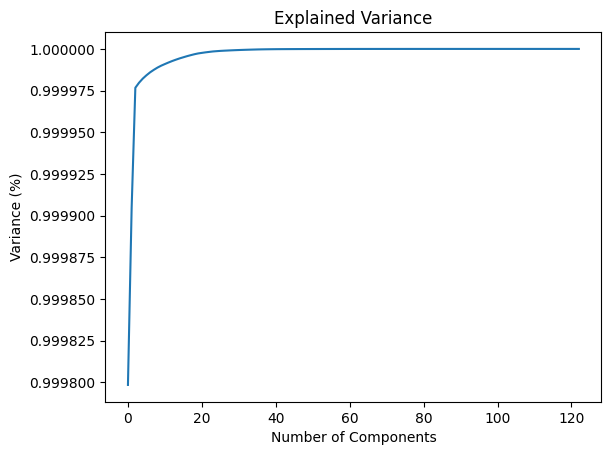

In [160]:
#add PCA levels to the data
columns_to_drop = [col for col in full_data.columns if 'time' in col]+["source_name"]
data_for_pca = full_data.drop(columns=columns_to_drop)

pca = PCA()
principal_components = pca.fit_transform(data_for_pca)
explained_variance = pca.explained_variance_ratio_

plt.plot(np.cumsum(explained_variance))
plt.xlabel('Number of Components')
plt.ylabel('Variance (%)')
plt.title('Explained Variance')
plt.show()

In [161]:
eigenvalues = pca.explained_variance_
n_components_kaiser = sum(eigenvalues > 1)
print(f"Number of components with eigenvalue > 1: {n_components_kaiser}")

components = pca.components_
num_components = pca.n_components_
feature_names = data_for_pca.columns

print("Top contributing variables per principal component:")
for i, comp in enumerate(components):
    component_df = pd.DataFrame(comp, index=feature_names, columns=['Weight'])
    component_df['Absolute Weight'] = component_df['Weight'].abs()
    sorted_component = component_df.sort_values('Absolute Weight', ascending=False)
    top_features = sorted_component.head(5)  # change count if more or fewer top features are desired
    print(f"Principal Component {i+1}:")
    print(top_features)
    print()
    

Number of components with eigenvalue > 1: 20
Top contributing variables per principal component:
Principal Component 1:
                                    Weight  Absolute Weight
index                             1.000000         1.000000
accel_vertical_inclination_min    0.000287         0.000287
accel_vertical_inclination_mean   0.000277         0.000277
accel_vertical_inclination_max    0.000267         0.000267
accel_horizontal_inclination_min  0.000139         0.000139

Principal Component 2:
                                     Weight  Absolute Weight
accel_vertical_inclination_max    -0.565812         0.565812
accel_vertical_inclination_mean   -0.560397         0.560397
accel_vertical_inclination_min    -0.554803         0.554803
accel_horizontal_inclination_max   0.088127         0.088127
accel_horizontal_inclination_mean  0.085244         0.085244

Principal Component 3:
                                     Weight  Absolute Weight
accel_horizontal_inclination_min  -0.569783  

In [162]:
full_data["SM_platform"] = full_data["source_name"].str.extract(r'([A-Za-z]+)')
PCs_full_data = pd.DataFrame(principal_components[:,eigenvalues > 1])
PCs_full_data.rename(columns=dict(zip(PCs_full_data.columns, [f"pc_{x}" for x in range(1,21)])), inplace=True)
full_data = pd.concat([full_data,PCs_full_data], axis=1)

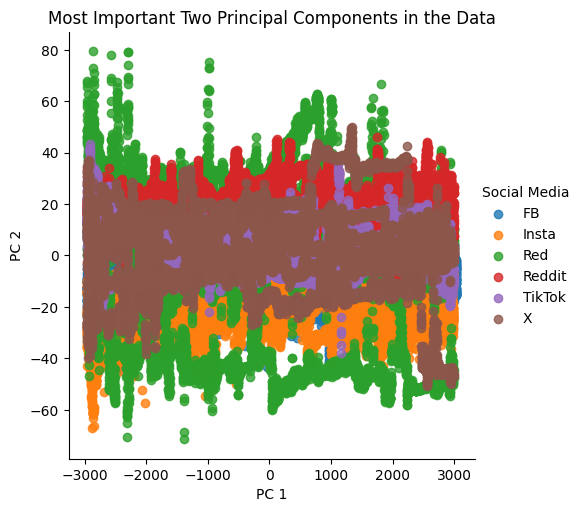

In [164]:
ax = sns.lmplot(x='pc_1', y='pc_2', data=full_data, 
                hue='SM_platform', fit_reg=False)
plt.title('Most Important Two Principal Components in the Data')
ax.set_xlabels("PC 1")
ax.set_ylabels("PC 2")
ax._legend.set_title("Social Media")

In [165]:
my_path = 'C:/Users/ameer/Desktop/AI/ML4QS/BackUp/Emir_Datasets'

full_data.to_parquet(my_path+"/full_dataset.parquet.gzip")

In [3]:
my_path = 'C:/Users/ameer/Desktop/AI/ML4QS/BackUp/Emir_Datasets'
full_data = pd.read_parquet(my_path+"/full_dataset.parquet.gzip")

In [4]:
random.seed(51)
testing_categories = [1,2,3,4,5,6]
random.shuffle(testing_categories)

testing_set = [f"{platform}{number}" for platform, number in zip(full_data["SM_platform"].unique(), testing_categories)]
testing_df = full_data[full_data["source_name"].isin(testing_set)]
training_df = full_data[~full_data["source_name"].isin(testing_set)]

#only select standardized columns
columns_to_select = [col for col in full_data.columns if 'zscore' in col]+["SM_platform", "index"]+[col for col in full_data.columns if 'pc' in col]
training_df = training_df.loc[:,columns_to_select]
testing_df = testing_df.loc[:,columns_to_select]

In [11]:
param_grid = { 
    'n_estimators': [25, 50, 100, 150], 
    'max_features': ['sqrt', 'log2', None], 
    'max_depth': [3, 6, 9], 
    'max_leaf_nodes': [3, 6, 9], 
} 

random_search = RandomizedSearchCV(RandomForestClassifier(), param_grid)

random_search.fit(training_df.drop(columns=["SM_platform"]), training_df["SM_platform"])

RandomizedSearchCV(cv=None, error_score=nan,
                   estimator=RandomForestClassifier(bootstrap=True,
                                                    ccp_alpha=0.0,
                                                    class_weight=None,
                                                    criterion='gini',
                                                    max_depth=None,
                                                    max_features='auto',
                                                    max_leaf_nodes=None,
                                                    max_samples=None,
                                                    min_impurity_decrease=0.0,
                                                    min_impurity_split=None,
                                                    min_samples_leaf=1,
                                                    min_samples_split=2,
                                                    min_weight_fraction_leaf=0.0,
            

In [12]:
print(random_search.best_estimator_) 

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=9, max_features='log2',
                       max_leaf_nodes=6, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)


Hyperoptimized model

In [13]:
model_grid = RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=9, max_features='log2',
                       max_leaf_nodes=6, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False) 

model_grid.fit(training_df.drop(columns=["SM_platform"]), training_df["SM_platform"])
y_pred_grid = model_grid.predict(testing_df.drop(columns=["SM_platform"]))
print(classification_report(y_pred_grid, testing_df["SM_platform"])) 
print(confusion_matrix(y_pred_grid, testing_df["SM_platform"]))
print(accuracy_score(y_pred_grid, testing_df["SM_platform"]))

              precision    recall  f1-score   support

          FB       0.98      0.50      0.66     11832
       Insta       0.45      0.39      0.42      6802
         Red       0.04      0.10      0.06      2587
      Reddit       0.57      0.75      0.65      4501
      TikTok       0.64      0.65      0.65      5836
           X       0.54      0.76      0.63      4209

    accuracy                           0.54     35767
   macro avg       0.54      0.53      0.51     35767
weighted avg       0.65      0.54      0.56     35767

[[5905 3163 1252  591  672  249]
 [  77 2678 3947    0   13   87]
 [   0    6  260   25    1 2295]
 [   0    5    2 3389 1040   65]
 [   0   18  466 1491 3810   51]
 [  14   81   28  459  419 3208]]
0.5382056085218218


                                   Feature  Importance
63                                    pc_2    0.138890
64                                    pc_3    0.132456
65                                    pc_4    0.105504
13    accel_zscore_vertical_inclination_sd    0.077803
14  accel_zscore_horizontal_inclination_sd    0.052798


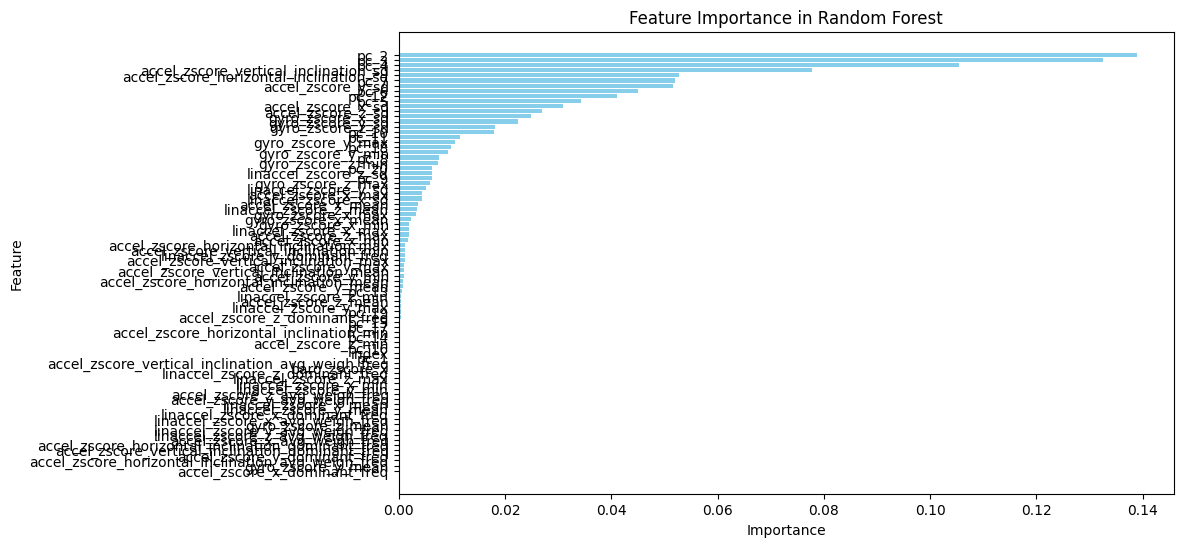

In [14]:
importances_gsmodel = model_grid.feature_importances_
feature_names_gsmodel = training_df.drop(columns=["SM_platform"]).columns

# Create a DataFrame for visualization
feature_importance_df_gsmodel = pd.DataFrame({
    'Feature': feature_names_gsmodel,
    'Importance': importances_gsmodel
}).sort_values(by='Importance', ascending=False)

print(feature_importance_df_gsmodel.head())

# Plot the feature importances
plt.figure(figsize=(10, 6))
plt.barh(feature_importance_df_gsmodel['Feature'], feature_importance_df_gsmodel['Importance'], color='skyblue')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Feature Importance in Random Forest')
plt.gca().invert_yaxis()
plt.show()

Simplified model

In [5]:
model_grid = RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features=None,
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=50,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False) 

model_grid.fit(training_df.drop(columns=["SM_platform"]), training_df["SM_platform"])
y_pred_grid = model_grid.predict(testing_df.drop(columns=["SM_platform"]))
print(classification_report(y_pred_grid, testing_df["SM_platform"])) 
print(confusion_matrix(y_pred_grid, testing_df["SM_platform"]))
print(accuracy_score(y_pred_grid, testing_df["SM_platform"]))

              precision    recall  f1-score   support

          FB       0.80      0.95      0.87      5050
       Insta       0.97      0.46      0.63     12576
         Red       0.03      0.04      0.03      3885
      Reddit       0.93      0.56      0.70      9854
      TikTok       0.21      0.97      0.34      1269
           X       0.43      0.82      0.56      3133

    accuracy                           0.56     35767
   macro avg       0.56      0.63      0.52     35767
weighted avg       0.76      0.56      0.60     35767

[[4819   52   36    0   15  128]
 [1171 5790 5601    0    0   14]
 [   1  101  156  321  141 3165]
 [   0    0    0 5515 4253   86]
 [   0    0   17   16 1233    3]
 [   5    8  145  103  313 2559]]
0.5611876869740263


                                 Feature  Importance
63                                  pc_2    0.256203
64                                  pc_3    0.158635
65                                  pc_4    0.150505
13  accel_zscore_vertical_inclination_sd    0.061612
67                                  pc_6    0.051872


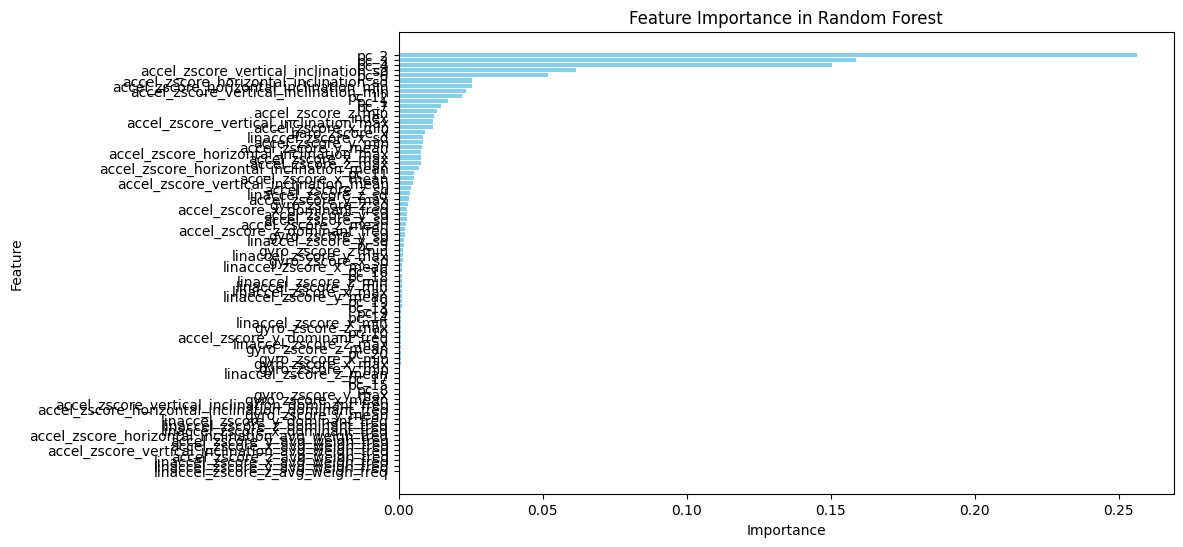

In [6]:
importances_gsmodel = model_grid.feature_importances_
feature_names_gsmodel = training_df.drop(columns=["SM_platform"]).columns

# Create a DataFrame for visualization
feature_importance_df_gsmodel = pd.DataFrame({
    'Feature': feature_names_gsmodel,
    'Importance': importances_gsmodel
}).sort_values(by='Importance', ascending=False)

print(feature_importance_df_gsmodel.head())

# Plot the feature importances
plt.figure(figsize=(10, 6))
plt.barh(feature_importance_df_gsmodel['Feature'], feature_importance_df_gsmodel['Importance'], color='skyblue')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Feature Importance in Random Forest')
plt.gca().invert_yaxis()
plt.show()

Default Model

In [7]:
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(training_df.drop(columns=["SM_platform"]), training_df["SM_platform"])

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=42, verbose=0,
                       warm_start=False)

In [8]:
y_pred = rf_model.predict(testing_df.drop(columns=["SM_platform"]))

In [9]:
print(classification_report(testing_df["SM_platform"], y_pred))
print(confusion_matrix(testing_df["SM_platform"], y_pred))
print(accuracy_score(testing_df["SM_platform"], y_pred))

              precision    recall  f1-score   support

          FB       0.99      0.99      0.99      5996
       Insta       0.50      1.00      0.66      5951
         Red       0.00      0.00      0.00      5955
      Reddit       0.57      1.00      0.72      5955
      TikTok       0.98      0.20      0.34      5955
           X       0.96      0.59      0.74      5955

    accuracy                           0.63     35767
   macro avg       0.67      0.63      0.58     35767
weighted avg       0.67      0.63      0.58     35767

[[5944   52    0    0    0    0]
 [  13 5934    0    0    4    0]
 [   0 5932    1    0   18    4]
 [   0    0   12 5942    0    1]
 [   9    2   69 4523 1220  132]
 [  25    3 2366   12    9 3540]]
0.6313361478457796


   Feature  Importance
63    pc_2    0.168399
64    pc_3    0.101744
65    pc_4    0.089917
67    pc_6    0.037621
68    pc_7    0.031419


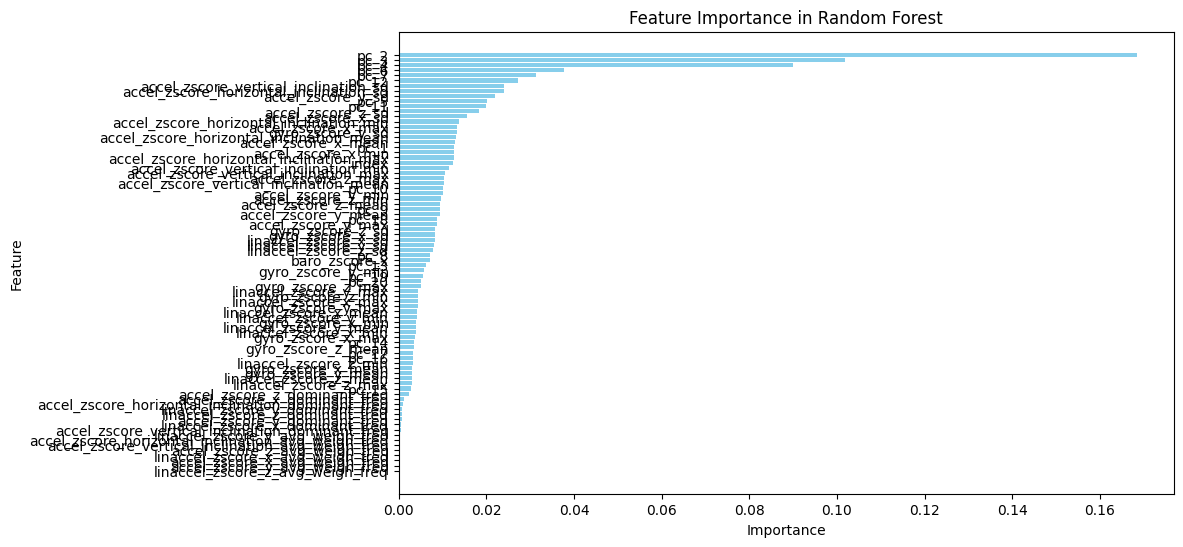

In [10]:
importances = rf_model.feature_importances_
feature_names = training_df.drop(columns=["SM_platform"]).columns

# Create a DataFrame for visualization
feature_importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': importances
}).sort_values(by='Importance', ascending=False)

print(feature_importance_df.head())

# Plot the feature importances
plt.figure(figsize=(10, 6))
plt.barh(feature_importance_df['Feature'], feature_importance_df['Importance'], color='skyblue')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Feature Importance in Random Forest')
plt.gca().invert_yaxis()
plt.show()

GradientBoosting model

[I 2024-06-16 00:17:25,070] A new study created in memory with name: no-name-698956f9-2634-4f39-bc5a-aeca48627765
[I 2024-06-16 00:27:54,402] Trial 0 finished with value: 0.6845975340397573 and parameters: {'n_estimators': 78, 'max_depth': 20, 'learning_rate': 0.18344399411956813, 'subsample': 0.6680328060513674, 'min_samples_split': 4, 'min_samples_leaf': 3, 'max_features': 'log2'}. Best is trial 0 with value: 0.6845975340397573.
[I 2024-06-16 00:46:57,198] Trial 1 finished with value: 0.7011491039226102 and parameters: {'n_estimators': 69, 'max_depth': 15, 'learning_rate': 0.04607790814445244, 'subsample': 0.9493077350162411, 'min_samples_split': 4, 'min_samples_leaf': 4, 'max_features': 'log2'}. Best is trial 1 with value: 0.7011491039226102.
[I 2024-06-16 00:59:35,210] Trial 2 finished with value: 0.7270668493303883 and parameters: {'n_estimators': 129, 'max_depth': 7, 'learning_rate': 0.02029631187796734, 'subsample': 0.9727965464963058, 'min_samples_split': 4, 'min_samples_leaf':

Best hyperparameters:  {'n_estimators': 103, 'max_depth': 4, 'learning_rate': 0.15055684961952356, 'subsample': 0.9973531068085224, 'min_samples_split': 7, 'min_samples_leaf': 5, 'max_features': 'log2'}
Accuracy: 0.7627142337909246
Classification Report:
              precision    recall  f1-score   support

          FB       0.97      0.99      0.98      5996
       Insta       0.50      0.98      0.66      5951
         Red       0.00      0.00      0.00      5955
      Reddit       0.80      0.97      0.88      5955
      TikTok       0.96      0.74      0.83      5955
           X       0.98      0.90      0.94      5955

    accuracy                           0.76     35767
   macro avg       0.70      0.76      0.71     35767
weighted avg       0.70      0.76      0.71     35767

Confusion Matrix:
[[5940   48    4    0    2    2]
 [ 141 5808    0    0    2    0]
 [  42 5868    0    0   24   21]
 [   0    0   11 5778  164    2]
 [   7    5    9 1465 4377   92]
 [   3    0  575   

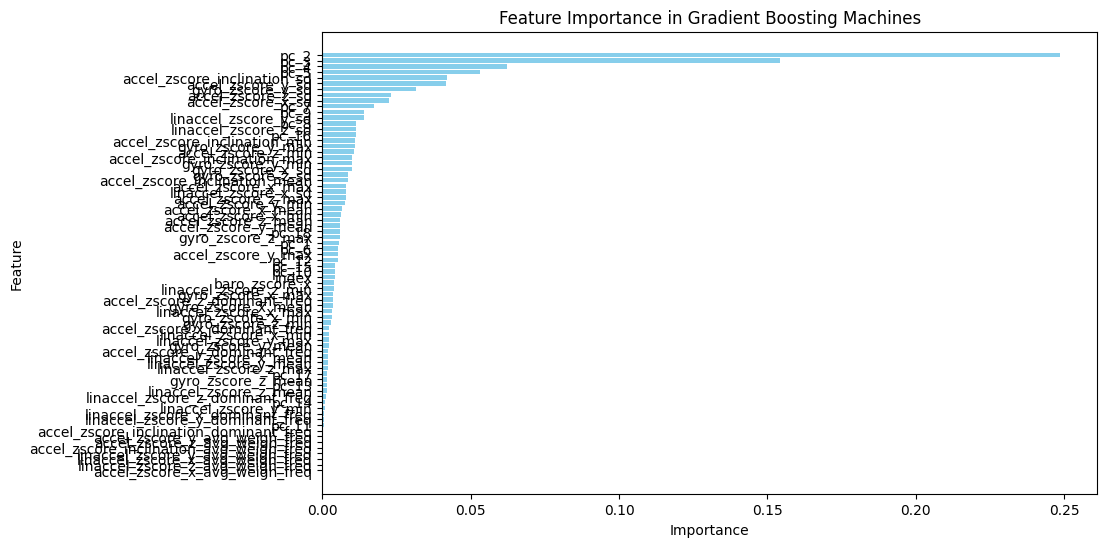

In [7]:
my_path = 'C:/Users/ameer/Desktop/AI/ML4QS/BackUp/Emir_Datasets'

full_data = pd.read_parquet(my_path+"/full_dataset.parquet.gzip")

# Split the dataset into training and testing sets
random.seed(51)
testing_categories = [1, 2, 3, 4, 5, 6]
random.shuffle(testing_categories)

testing_set = [f"{platform}{number}" for platform, number in zip(full_data["SM_platform"].unique(), testing_categories)]
testing_df = full_data[full_data["source_name"].isin(testing_set)]
training_df = full_data[~full_data["source_name"].isin(testing_set)]

# Only select standardized columns
columns_to_select = [col for col in full_data.columns if 'zscore' in col] + ["SM_platform", "index"] + [col for col in
                                                                                                        full_data.columns
                                                                                                        if 'pc' in col]
training_df = training_df.loc[:, columns_to_select]
testing_df = testing_df.loc[:, columns_to_select]

# Separate features and target
X_train = training_df.drop(columns=["SM_platform"])
y_train = training_df["SM_platform"]
X_test = testing_df.drop(columns=["SM_platform"])
y_test = testing_df["SM_platform"]

# Encode the target variable
label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train)
y_test_encoded = label_encoder.transform(y_test)


# Optuna objective function for hyperparameter tuning
def objective(trial):
    param = {
        'n_estimators': trial.suggest_int('n_estimators', 50, 200),
        'max_depth': trial.suggest_int('max_depth', 3, 20),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3, log=True),
        'subsample': trial.suggest_float('subsample', 0.5, 1.0),
        'min_samples_split': trial.suggest_int('min_samples_split', 2, 10),
        'min_samples_leaf': trial.suggest_int('min_samples_leaf', 1, 10),
        'max_features': trial.suggest_categorical('max_features', ['sqrt', 'log2', None])
    }

    gbm = GradientBoostingClassifier(**param, random_state=42)
    gbm.fit(X_train, y_train_encoded)
    y_pred = gbm.predict(X_test)
    accuracy = accuracy_score(y_test_encoded, y_pred)

    return accuracy


# Create a study object and optimize the objective function
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=50)

# Print the best hyperparameters
print("Best hyperparameters: ", study.best_params)

# Train the final model with the best hyperparameters
best_params = study.best_params
gbm_model = GradientBoostingClassifier(**best_params, random_state=42)
gbm_model.fit(X_train, y_train_encoded)

# Make predictions
y_pred = gbm_model.predict(X_test)

# Decode the predictions back to original labels
y_pred_labels = label_encoder.inverse_transform(y_pred)
y_test_labels = label_encoder.inverse_transform(y_test_encoded)

# Evaluate the model
print(f"Accuracy: {accuracy_score(y_test_labels, y_pred_labels)}")
print("Classification Report:")
print(classification_report(y_test_labels, y_pred_labels))
print("Confusion Matrix:")
print(confusion_matrix(y_test_labels, y_pred_labels))

# Feature importance
importances = gbm_model.feature_importances_
feature_names = X_train.columns

# Create a DataFrame for visualization
feature_importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': importances
}).sort_values(by='Importance', ascending=False)

print(feature_importance_df.head())

# Plot the feature importances
plt.figure(figsize=(10, 6))
plt.barh(feature_importance_df['Feature'], feature_importance_df['Importance'], color='skyblue')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Feature Importance in Gradient Boosting Machines')
plt.gca().invert_yaxis()
plt.show()
